In [1]:
!nvidia-smi

Sun Sep 10 23:01:43 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P4               9W /  55W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


torch.cuda.amp.autocast(enabled=False)

# REPRODUCE
torch.backends.cudnn.deterministi=True
random.seed(hash('setting random seeds')% 2**32-1)
np.random.seed(hash('improves reproducibility')%2**32-1)
torch.manual_seed(hash("by removing stochasticity")%2**32-1)
torch.cuda.manual_seed_all(hash('so runs are repetable')%2**32-1)

In [3]:
from utils import (
    device,
    cuda,
    show_random_images,
    calculate_mean_std_mnist
)
from model import Net
from transforms import (
    train_transforms,
    test_transforms,
    custom_augmentation,
    MNISTDataset
)

In [4]:
mnist_data = datasets.MNIST( root='../data', download=False, transform=transforms.ToTensor() ,)
mean,std= calculate_mean_std_mnist(mnist_data)

print(mean,std)

0.13065974414348602 0.3015038073062897


In [5]:
train_data = datasets.MNIST('../data', train=True, download=False, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=False, transform=test_transforms)

In [6]:
CONFIG = {
    "batch_size":64,
    'shuffle':True,
    'num_workers':4,
    'pin_memory':True,
    'cuda': True if torch.cuda.is_available() else False,
    'dropout_rate':0.01,
    'lr':0.2,
    'step_size':5,
    'num_epochs':15
}

In [7]:
if torch.cuda.is_available():
    kwargs = {'batch_size': CONFIG['batch_size'], 'shuffle': CONFIG['shuffle'], 'num_workers': CONFIG['num_workers'], 'pin_memory':CONFIG['pin_memory']}
else:
    kwargs = {'batch_size':32,'shuffle':True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

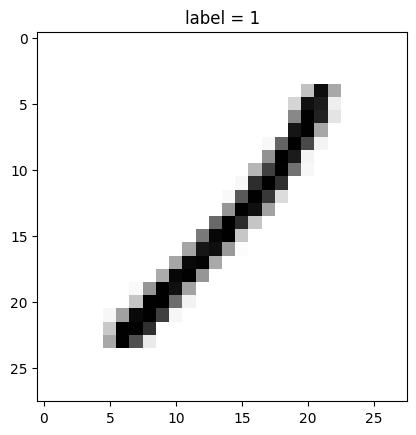

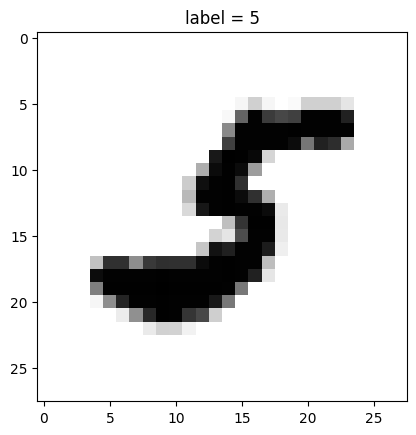

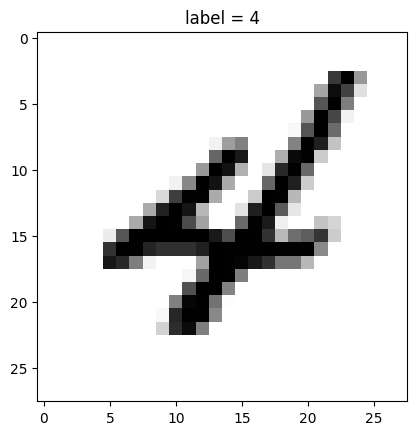

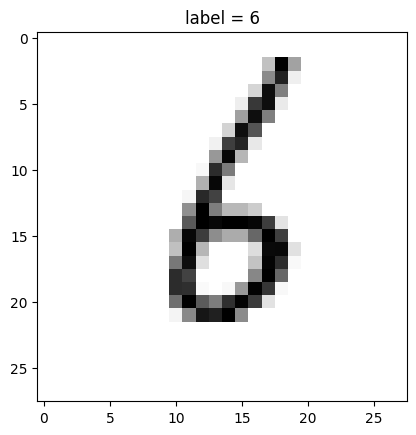

In [8]:
show_random_images(train_data,4)

In [9]:

# Data to plot accuracy and loss graphs (INIT)
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [10]:
model = Net().to(device)

In [11]:
for name,weights in model.named_parameters():
    print(f"{name}\t\t {weights.shape}")

conv1.0.weight		 torch.Size([3, 1, 3, 3])
conv1.1.weight		 torch.Size([3])
conv1.1.bias		 torch.Size([3])
conv1.4.weight		 torch.Size([8, 3, 3, 3])
conv1.5.weight		 torch.Size([8])
conv1.5.bias		 torch.Size([8])
conv1.8.weight		 torch.Size([10, 8, 3, 3])
conv1.9.weight		 torch.Size([10])
conv1.9.bias		 torch.Size([10])
trans1.1.weight		 torch.Size([8, 10, 1, 1])
trans1.2.weight		 torch.Size([8])
trans1.2.bias		 torch.Size([8])
conv2.0.weight		 torch.Size([10, 8, 3, 3])
conv2.1.weight		 torch.Size([10])
conv2.1.bias		 torch.Size([10])
conv2.4.weight		 torch.Size([12, 10, 3, 3])
conv2.5.weight		 torch.Size([12])
conv2.5.bias		 torch.Size([12])
conv2.8.weight		 torch.Size([12, 12, 3, 3])
conv2.9.weight		 torch.Size([12])
conv2.9.bias		 torch.Size([12])
trans2.1.weight		 torch.Size([8, 12, 1, 1])
trans2.2.weight		 torch.Size([8])
trans2.2.bias		 torch.Size([8])
conv3.0.weight		 torch.Size([12, 8, 3, 3])
conv3.1.weight		 torch.Size([12])
conv3.1.bias		 torch.Size([12])
conv3.4.weight		 torc

In [12]:
summary(model=model,input_size=(1,28,28),device='cuda');

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              27
       BatchNorm2d-2            [-1, 3, 28, 28]               6
              ReLU-3            [-1, 3, 28, 28]               0
         Dropout2d-4            [-1, 3, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             216
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
         Dropout2d-8            [-1, 8, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             720
      BatchNorm2d-10           [-1, 10, 28, 28]              20
             ReLU-11           [-1, 10, 28, 28]               0
        Dropout2d-12           [-1, 10, 28, 28]               0
        MaxPool2d-13           [-1, 10, 15, 15]               0
           Conv2d-14            [-1, 8,

In [13]:

optimizer = optim.SGD(model.parameters(), lr=CONFIG['lr'], momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=CONFIG['step_size'], gamma=0.1, verbose=True)
# New Line
criterion =  F.nll_loss
num_epochs = CONFIG['num_epochs']

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 1


Train: Loss=0.1476 Batch_id=937 Accuracy=91.77: 100%|████████████| 938/938 [00:18<00:00, 52.06it/s]


Test set: Average loss: 0.0706, Accuracy: 9786/10000 (97.8600%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 2


Train: Loss=0.0857 Batch_id=937 Accuracy=96.64: 100%|████████████| 938/938 [00:18<00:00, 51.01it/s]


Test set: Average loss: 0.0503, Accuracy: 9844/10000 (98.4400%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 3


Train: Loss=0.1112 Batch_id=937 Accuracy=97.40: 100%|████████████| 938/938 [00:17<00:00, 52.47it/s]


Test set: Average loss: 0.0348, Accuracy: 9885/10000 (98.8500%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 4


Train: Loss=0.0190 Batch_id=937 Accuracy=97.62: 100%|████████████| 938/938 [00:17<00:00, 52.23it/s]


Test set: Average loss: 0.0378, Accuracy: 9887/10000 (98.8700%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 5


Train: Loss=0.0341 Batch_id=937 Accuracy=97.86: 100%|████████████| 938/938 [00:18<00:00, 52.08it/s]


Test set: Average loss: 0.0321, Accuracy: 9902/10000 (99.0200%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 6


Train: Loss=0.0696 Batch_id=937 Accuracy=98.37: 100%|████████████| 938/938 [00:17<00:00, 54.38it/s]


Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.2700%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 7


Train: Loss=0.1460 Batch_id=937 Accuracy=98.53: 100%|████████████| 938/938 [00:17<00:00, 54.19it/s]


Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.3000%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 8


Train: Loss=0.0090 Batch_id=937 Accuracy=98.61: 100%|████████████| 938/938 [00:17<00:00, 52.75it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.3500%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 9


Train: Loss=0.0171 Batch_id=937 Accuracy=98.64: 100%|████████████| 938/938 [00:17<00:00, 53.46it/s]


Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.4000%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 10


Train: Loss=0.0351 Batch_id=937 Accuracy=98.59: 100%|████████████| 938/938 [00:17<00:00, 54.34it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.3200%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 11


Train: Loss=0.0026 Batch_id=937 Accuracy=98.66: 100%|████████████| 938/938 [00:17<00:00, 54.04it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.3400%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 12


Train: Loss=0.0211 Batch_id=937 Accuracy=98.72: 100%|████████████| 938/938 [00:17<00:00, 55.02it/s]


Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.3400%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 13


Train: Loss=0.1243 Batch_id=937 Accuracy=98.72: 100%|████████████| 938/938 [00:17<00:00, 54.07it/s]


Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.3400%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 14


Train: Loss=0.0339 Batch_id=937 Accuracy=98.74: 100%|████████████| 938/938 [00:17<00:00, 54.50it/s]


Test set: Average loss: 0.0189, Accuracy: 9933/10000 (99.3300%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 15


Train: Loss=0.0821 Batch_id=937 Accuracy=98.65: 100%|████████████| 938/938 [00:17<00:00, 54.39it/s]


Test set: Average loss: 0.0185, Accuracy: 9937/10000 (99.3700%)

Adjusting learning rate of group 0 to 2.0000e-04.


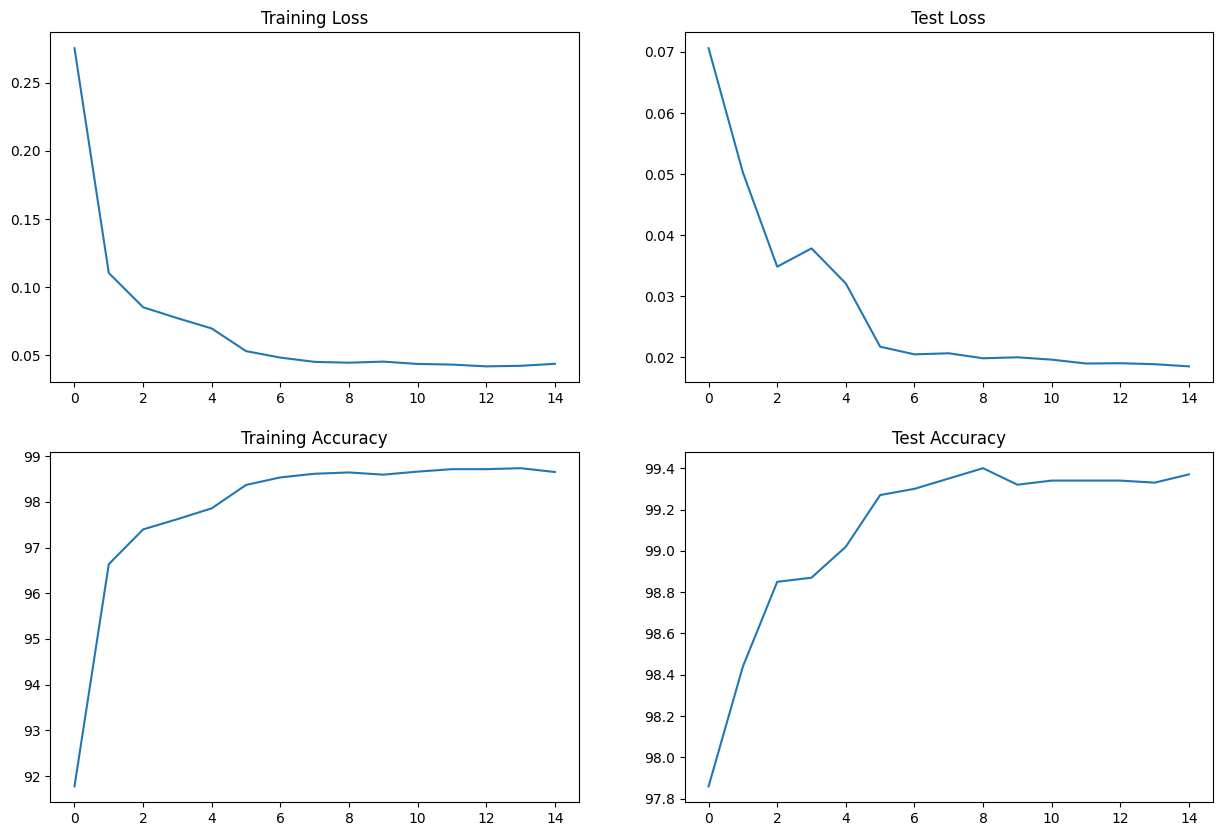

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [ ]:
fig = plt.figure()

num_of_imgs=60

dataiter = iter(train_loader)
imgs,labels = next(dataiter)

print(imgs.shape,labels.shape)

plt.imshow(imgs[0].numpy().squeeze(),cmap='binary')

for idx in range(1,num_of_imgs+1):
    plt.subplot(6,10,idx)
    plt.axis('off')
    plt.imshow(imgs[idx].numpy().squeeze(),cmap='binary')
plt.show()
